In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_

In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
#from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

%run '/GRRN.ipynb'

torch.Size([1, 105])


In [3]:
import zipfile

def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


zip_file_path = '/Datasets for Interpretation copy.zip'
extract_to = '/content'

unzip_file(zip_file_path, extract_to)

In [4]:
model_path = '/GRRNN_WriterIdentification_dataset_CERUG-EN_model_horzontal_aug_16-model_epoch_49.pth'
model = GrnnNet(1,num_classes=105,mode='vertical').to('cuda')

model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))

<All keys matched successfully>

In [5]:
target_layers = [model.net.conv4]
print(target_layers)

[Sequential(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)]


In [6]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_VIRIDIS,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [7]:
import os
import pickle
from PIL import Image
from scipy import misc
import torch.utils.data as data
import torch
from torchvision.transforms import Compose, ToTensor
import random


In [8]:
scale_size=(64,128)
is_training = False

def transform():
  return Compose([ToTensor(),])

def resizing(image):
  w,h = image.size[:2]
  ratio_h = float(scale_size[0])/float(h)
  ratio_w = float(scale_size[1])/float(w)

  if ratio_h < ratio_w:
    ratio = ratio_h
    hfirst = False
  else:
    ratio = ratio_w
    hfirst = True


  nh = int(ratio * h)
  nw = int(ratio * w)

  imre = image.resize((nw, nh))
  #imre = misc.imresize(image,(nh,nw))
  im_array = np.array(imre)


  # Invert the image
  im_array = 255 - im_array
  imre = Image.fromarray(im_array)

  if imre is None:
      raise ValueError("The 'imre' variable is not defined.")

  if not isinstance(imre, Image.Image):
      raise TypeError("The 'imre' variable is not an image.")

  try:
    imre.verify()
  except Exception as e:
    raise ValueError("The image data in 'imre' is corrupted.") from e
    #imre = 255 - imre

  cw, ch = imre.size
  if is_training:
      new_img = np.zeros(scale_size)
      dy = int((scale_size[0]-ch))
      dx = int((scale_size[1]-cw))
      dy = random.randint(0,dy)
      dx = random.randint(0,dx)
  else:
      new_img = np.zeros(scale_size)
      dy = int((scale_size[0]-ch)/2.0)
      dx = int((scale_size[1]-cw)/2.0)

      #new_img = np.zeros(self.scale_size)
      #dy = int((self.scale_size[0]-ch)/2.0)
      #dx = int((self.scale_size[1]-cw)/2.0)

  imre = imre.convert('F')
  #imre = imre.astype('float')

  new_img[dy:dy+ch,dx:dx+cw] = imre
  #new_img /= 256.0
  #print(new_img.shape)

  return new_img


----------------------------------------------------
writer8181
----------------------------------------------------
/content/Datasets for Interpretation copy/CERUG/writer8181/Writer8181_03-02-line-3-n-8-y-564-x-1681-h-108-w-185.png
/content/Datasets for Interpretation copy/CERUG/writer8181/Writer8181_03-01-line-0-n-6-y-24-x-1310-h-117-w-224.png


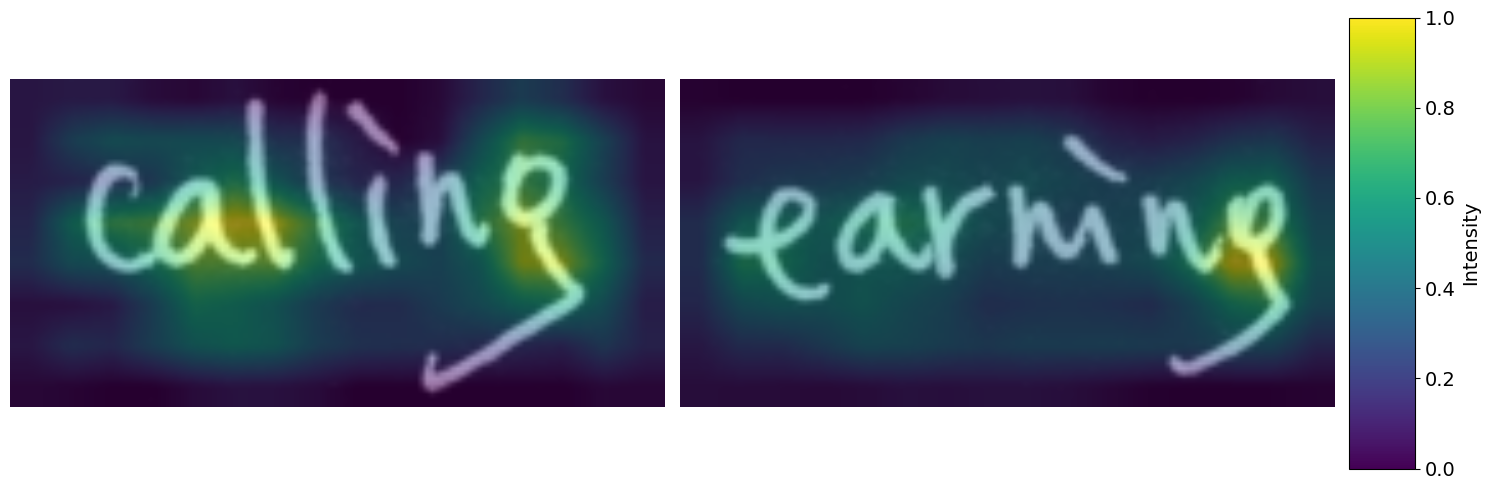

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image

path = "/content/Datasets for Interpretation copy/CERUG"

for folder_name in os.listdir(path):
    if folder_name != '.DS_Store':
        folder_path = os.path.join(path, folder_name)
        print("----------------------------------------------------")
        print(folder_name)
        print("----------------------------------------------------")

        visualizations = []

        for filename in os.listdir(folder_path):
            filepath = os.path.join(folder_path, filename)
            if os.path.isfile(filepath) and filepath.endswith('.png'):
                image = Image.open(filepath).convert('L')
                image = resizing(image)
                image = image / 255.0

                rgb_img = np.stack((image, image, image), axis=-1)
                img_tensor = transform()(image)
                img_tensor = img_tensor.float()

                cam = GradCAM(model=model, target_layers=target_layers)
                grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=None)
                grayscale_cam = grayscale_cam[0, :]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
                visualizations.append(visualization)
                print(filepath)

        num_images = len(visualizations)
        fig = plt.figure(figsize=(15, 5))
        gs = gridspec.GridSpec(1, num_images + 1, width_ratios=[1] * num_images + [0.1])

        for i, vis in enumerate(visualizations):
            ax = fig.add_subplot(gs[i])
            im = ax.imshow(vis, interpolation='bilinear')
            ax.axis('off')
            im.set_clim(0, 1)


        cbar = plt.colorbar(im, cax=ax_cbar, pad=0.1)
        cbar.ax.set_ylabel('Intensity', fontsize=14)

        cbar.ax.tick_params(labelsize=14)
        plt.subplots_adjust(wspace=0.3)
        plt.tight_layout()

        plt.savefig(f"{folder_name}_visualization.svg", format='svg', dpi=300, bbox_inches='tight')

        plt.show()


In [12]:
model_path = '/GRRNN_WriterIdentification_dataset_ICDAR_model_horzontal_aug_16-model_epoch_29.pth'
model = GrnnNet(1,num_classes=699,mode='vertical').to('cuda')

model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))

<All keys matched successfully>

In [13]:
target_layers = [model.net.conv4]
print(target_layers)

[Sequential(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)]


----------------------------------------------------
noise
----------------------------------------------------
/content/Datasets for Interpretation copy/ICDAR17/noise/564-IMG_MAX_921970_7.png
/content/Datasets for Interpretation copy/ICDAR17/noise/554-IMG_MAX_108468_221.png


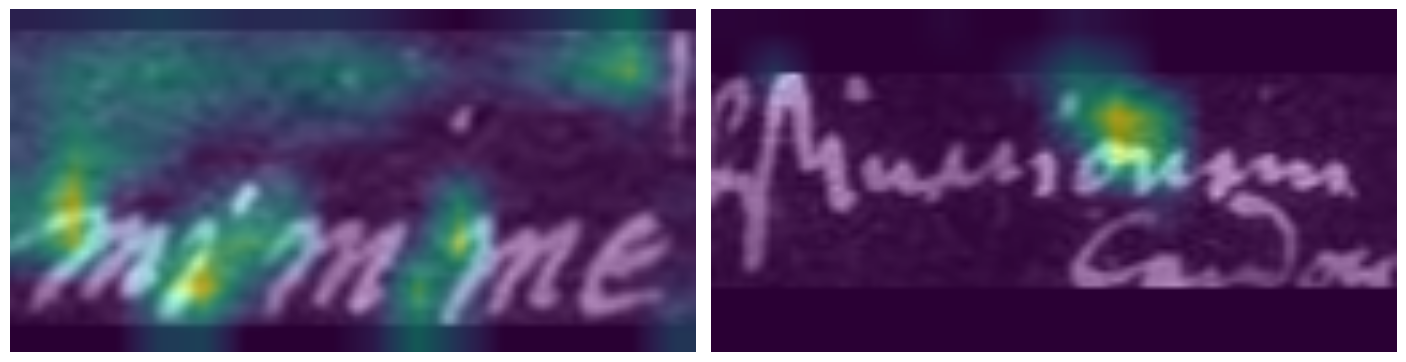

----------------------------------------------------
writer477&488
----------------------------------------------------
/content/Datasets for Interpretation copy/ICDAR17/writer477&488/488-IMG_MAX_10755_106.png
/content/Datasets for Interpretation copy/ICDAR17/writer477&488/477-IMG_MAX_1070199_312.png


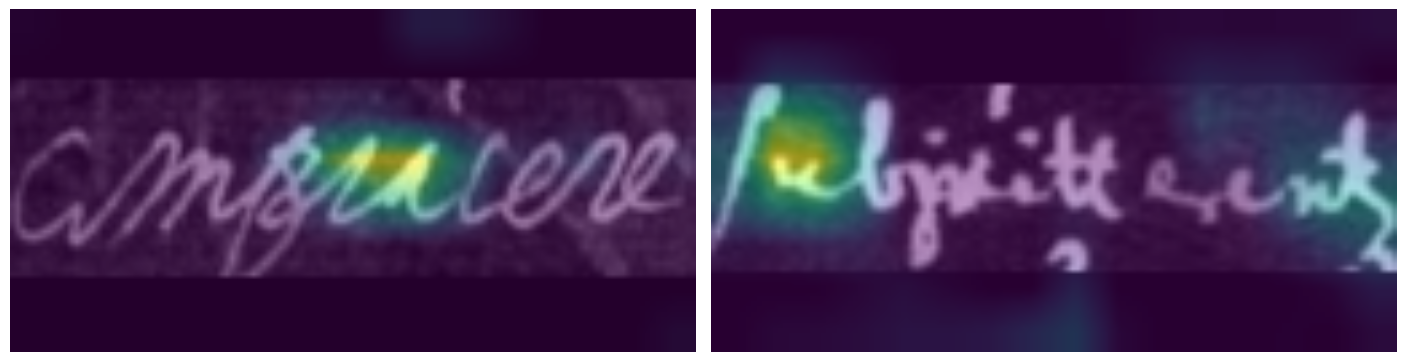

----------------------------------------------------
writer477
----------------------------------------------------
/content/Datasets for Interpretation copy/ICDAR17/writer477/477-IMG_MAX_1070199_312.png
/content/Datasets for Interpretation copy/ICDAR17/writer477/477-IMG_MAX_808104_247.png


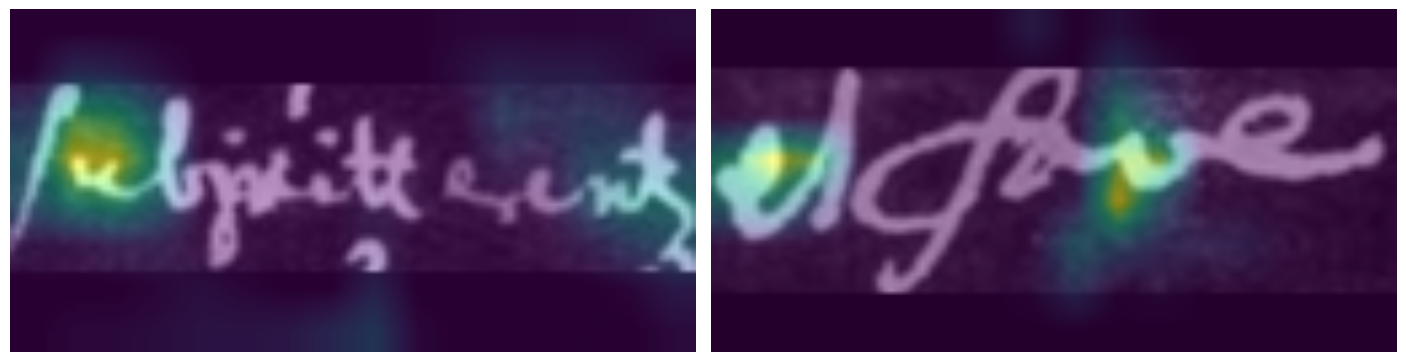

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image

path = "/content/Datasets for Interpretation copy/ICDAR17"

for folder_name in os.listdir(path):
    if folder_name != '.DS_Store':
        folder_path = os.path.join(path, folder_name)
        print("----------------------------------------------------")
        print(folder_name)
        print("----------------------------------------------------")

        visualizations = []

        for filename in os.listdir(folder_path):
            filepath = os.path.join(folder_path, filename)
            if os.path.isfile(filepath) and filepath.endswith('.png'):
                image = Image.open(filepath).convert('L')
                image = resizing(image)
                image = image / 255.0

                rgb_img = np.stack((image, image, image), axis=-1)
                img_tensor = transform()(image)
                img_tensor = img_tensor.float()

                cam = GradCAM(model=model, target_layers=target_layers)
                grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=None)
                grayscale_cam = grayscale_cam[0, :]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
                visualizations.append(visualization)
                print(filepath)

        num_images = len(visualizations)
        fig = plt.figure(figsize=(15, 5))
        gs = gridspec.GridSpec(1, num_images + 1, width_ratios=[1] * num_images + [0.1])

        for i, vis in enumerate(visualizations):
            ax = fig.add_subplot(gs[i])
            im = ax.imshow(vis, interpolation='bilinear')
            ax.axis('off')
            im.set_clim(0, 1)


        cbar = plt.colorbar(im, cax=ax_cbar, pad=0.1)
        cbar.ax.set_ylabel('Intensity', fontsize=14)

        cbar.ax.tick_params(labelsize=14)
        plt.subplots_adjust(wspace=0.3)
        plt.tight_layout()

        plt.savefig(f"{folder_name}_visualization.svg", format='svg', dpi=300, bbox_inches='tight')

        plt.show()
